In [1]:
import torch.nn.functional as F
import gym
import cv2
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import math ,random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env=gym.make('CartPole-v0')

In [3]:
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    
    screen = env.render(mode='rgb_array')
    
    screen_height, screen_width,_ = screen.shape
    screen = screen[int(screen_height*0.4):int(screen_height * 0.8),:]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[ :, slice_range,:]
    
    width = int(screen.shape[1] * 30 / 100)
    height = int(screen.shape[0] * 30 / 100)
    dim = (width, height)
    # resize image
    state = cv2.resize(screen, dim, interpolation = cv2.INTER_AREA) 
    screen=state.transpose((2, 0, 1))
    
    
    
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen=np.expand_dims(screen,0)
    screen = T.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    
    return screen


In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        self.device='cuda' if T.cuda.is_available() else 'cpu'
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = x.to(self.device)
        x = self.features(x) #convoltion block
        x = x.view(x.size(0), -1)
        x = self.fc(x) 
        return x
    
    def feature_size(self):
        return self.features(T.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            
            q_value = self.forward(state)
            action  = T.argmax(q_value).item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [5]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 3000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [7]:
device= 'cuda' if T.cuda.is_available() else 'cpu'
model=CnnDQN([3, 48, 108],2)
model=model.to(device)
model_target=CnnDQN([3, 48, 108],2)
model_target=model_target.to(device)
model_target.load_state_dict(model.state_dict())
model_target.eval()
optimizer = T.optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)
crit=nn.MSELoss()
gamma=0.999

In [8]:
def compute_loss(batch_size):
    state,action,reward,next_state,done=replay_buffer.sample(batch_size)

    state=T.FloatTensor(state)
    action=T.tensor(action).cuda()
    reward=T.tensor(reward).cuda()
    next_state=T.FloatTensor(next_state)
    done=T.tensor(done).float().cuda()

    q_values      = model(state)
    next_q_values = model_target(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = crit(q_value,expected_q_value)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [9]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

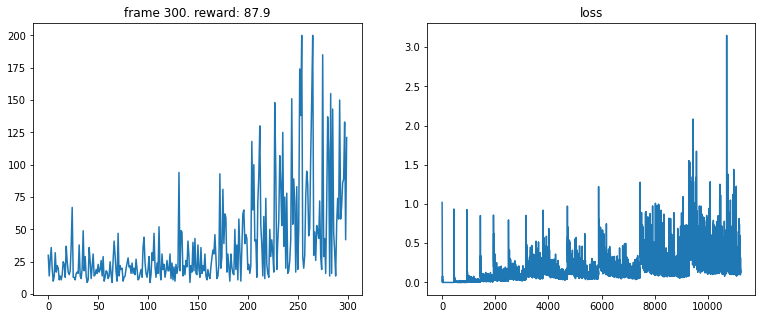

In [10]:
num_frames = 300
batch_size = 128
gamma      = 1

losses = []
all_rewards = []
episode_reward = 0
env.reset()
s1=get_screen()
s2=get_screen()
state=s2-s1
es=0
for frame_idx in range(1, num_frames + 1):
    done =0
    while not done:
        epsilon = epsilon_by_frame(es)
        es+=1
        action = model.act(state, epsilon)

        _, reward, done, _ = env.step(action)
        s1=s2
        s2=get_screen()
        next_state=s2-s1

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward


            

        if len(replay_buffer) > batch_size:
            loss = compute_loss(batch_size)
            losses.append(loss.item())
    env.reset()
    s1=get_screen()
    s2=get_screen()
    state=s2-s1
    all_rewards.append(episode_reward)
    episode_reward = 0
    if frame_idx % 25==0:
        model_target.load_state_dict(model.state_dict())
        
    plot(frame_idx, all_rewards, losses)
    


In [11]:
env.close()